# 0.0. IMPORTS

In [5]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import datetime              
from tabulate              import tabulate
from scipy.stats           import chi2_contingency
from IPython.display       import Image
from IPython.core.display  import HTML

## 0.1 Helper Function

In [3]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [6]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2 Loading Data

In [7]:
df_raw = pd.read_csv('data/train.csv', low_memory=False)

In [8]:
df_raw.sample()

,date,store,item,sales
419608,2016-12-25,10,23,26


# 1.0 STEP 01 - DESCRIPTION OF DATA

In [9]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [10]:
df1.columns

# It's not necessary to change the name or the format of the column names.

Index(['date', 'store', 'item', 'sales'], dtype='object')

## 1.2 Data Dimensions

In [11]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )
# Evaluate the possibilite do use this project in your computer

Number of Rows: 913000
Number of Cols: 4


## 1.3 Data Types

In [12]:
df1.dtypes
# Observe date. It has a different data type.

date     object
store     int64
item      int64
sales     int64
dtype: object

In [13]:
# I will use "to_date" to change to datetime.
df1['date'] = pd.to_datetime( df1['date'] )

In [14]:
df1.dtypes
# We can see that everything is ok!

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

## 1.4 Check NA

In [15]:
df1.isna().sum()
# No missing values.

date     0
store    0
item     0
sales    0
dtype: int64

## 1.7. Descriptive Statistical

In [16]:
# As we not have categorical variables, I will just separate numeric values from the datetime value.
num_attributes = df1.select_dtypes( include=['int64'] )

In [17]:
num_attributes.sample()

,store,item,sales
184612,2,11,120


### 1.7.1 Numerical Attributes

In [19]:

# Central Tendency - mean, median
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T
d2 = pd.DataFrame( num_attributes.apply( min ) ).T
d3 = pd.DataFrame( num_attributes.apply( max ) ).T
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

# concatenate
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ( ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis'])

In [20]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,10.0,9.0,5.500000,5.5,2.872281,0.000000,-1.224243
1,item,1.0,50.0,49.0,25.500000,25.5,14.430870,0.000000,-1.200960
2,sales,0.0,231.0,231.0,52.250287,47.0,28.801128,0.867112,0.509070


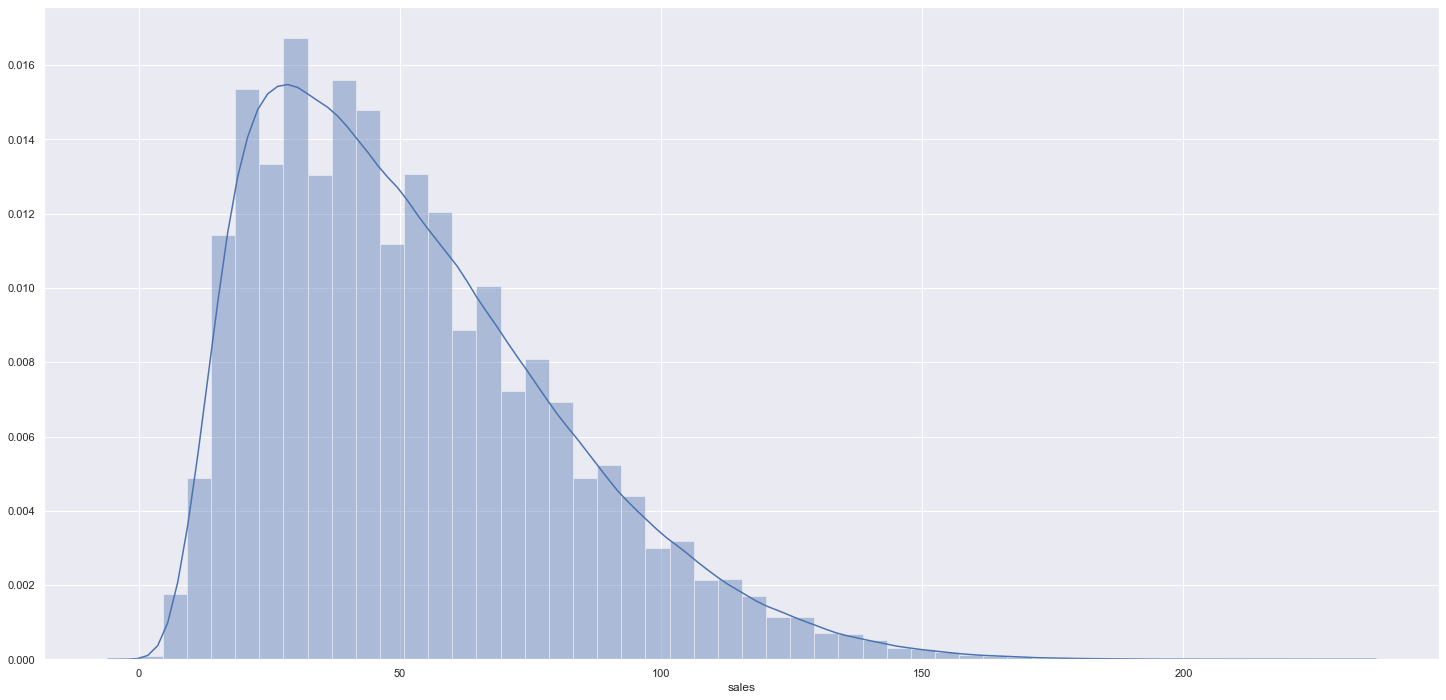

In [21]:
sns.distplot( df1['sales'] )

# 2.0 STEP 02 - FEATURE ENGINEERING

In [22]:
df2 = df1.copy()

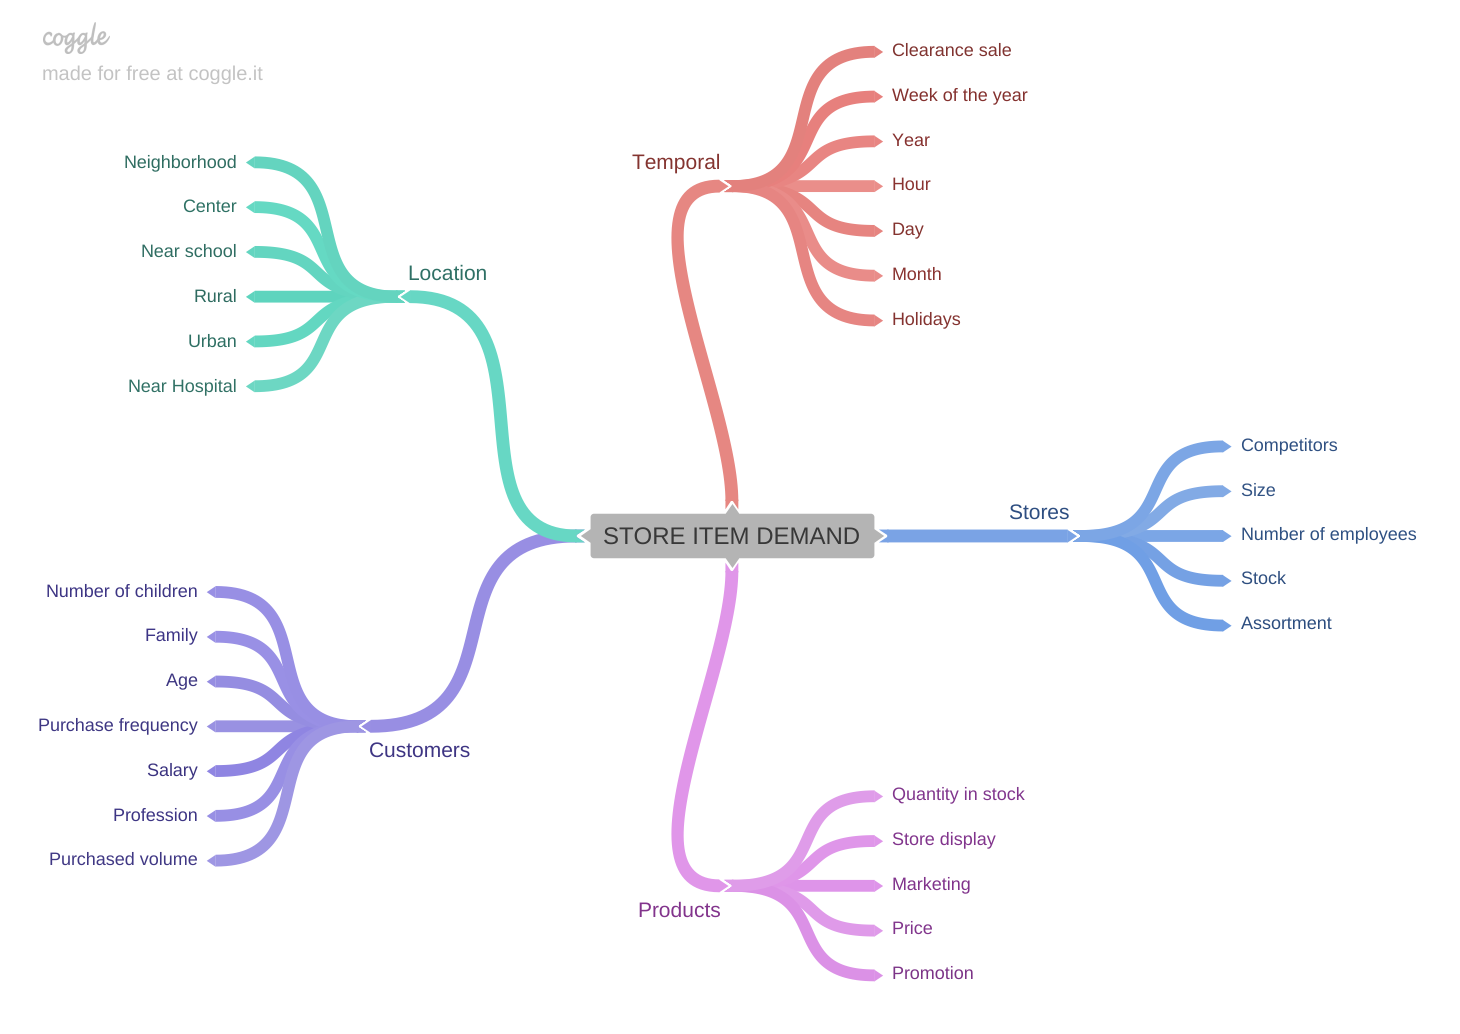

In [23]:
Image( "image/Hyphoteses_Map.png")

## 2.1 Creation of Hyphoteses

### 2.1.1. Shop Hypotheses

**1.** Stores with more employees should sell more items.

**2.** Stores with greater inventory capacity should sell more items.

**3.** Larger stores should sell more items.

**4.** Stores with closer competitors should sell less items.

**5.** Stores with longer competitors should sell more items.

### 2.1.2. Product Hypotheses

**1.** Stores that invest more in Marketing should sell more items.

**2.** Stores with greater product exposure should sell more items.

**3.** Stores with lower prices should sell more items.

**4.** Stores with more aggressive promotions (bigger discounts), should sell more items.

**5.** Stores with active promotions for longer should sell more items.

**6.** Stores with more promotion days should venerate more items.

**7.** Stores with more consecutive promotions should sell more items.

### 2.1.3 Time Hyphoteses

**1.** Stores open during the Christmas holiday should sell more items.

**2.** Stores should be selling more items over the years.

**3.** Stores should sell more items in the second half of the year.

**4.** Stores should sell more items after the 10th of each month.

**5.** Stores should sell less items on weekends.

**6.** Stores should sell less items during school holidays.

## 2.2 Final List of Hyphoteses

In [24]:
# As we only have information on sales dates in this dataset, I will use only the time hypothesis items in the final hypothesis list.

**1.** Stores should be selling more items over the years.

**2.** Stores should sell more items in the second half of the year.

**3.** Stores should sell more items after the 10th of each month.

**4.** Stores should sell less items on weekends.

## 2.3 Feature Engineering

In [25]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# day of week
df2['day_of_week'] = df2['date'].dt.dayofweek

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime( '%Y-%W' )

In [28]:
df2.sample(5).T

,707744,269231,49625,265296,432854
date,2015-12-19 00:00:00,2015-03-21 00:00:00,2013-11-20 00:00:00,2014-06-11 00:00:00,2013-04-03 00:00:00
store,8,8,8,6,8
item,39,15,3,15,24
sales,36,90,48,58,52
year,2015,2015,2013,2014,2013
month,12,3,11,6,4
day,19,21,20,11,3
day_of_week,5,5,2,2,2
week_of_year,51,12,47,24,14
year_week,2015-50,2015-11,2013-46,2014-23,2013-13


# 3.0 STEP 03 - VARIABLE FILTERING

In [27]:
df3 = df2.copy()